In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import construction as cs
from ETN import count_ETN
from ETNgen import generate_seed_graphs,generate_graph_g2,get_dict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
def get_number_of_interactions(graphs):
    nb_inter = []
    for g in graphs:
        nb_inter.append(len(g.edges()))
    return nb_inter
    
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

from matplotlib.lines import Line2D

# load data as an array of static graphs

In [50]:
file_name = "LH10"

data_in = cs.load_data("Datasets/"+file_name+".dat")

gap = 299 
# gap = 599 used  for SMS and calls
graphs = cs.build_graphs(data_in,gap=gap)

print(len(graphs))

1159


### decide local and global splitting

![title](img/Local_global_split.svg)

here you can set local and global split, so you can decide how many dictionary do you want in a global split

In [51]:
local_split = 3600*1 # 1 hours
global_slpit = 3600*24 # 1 day

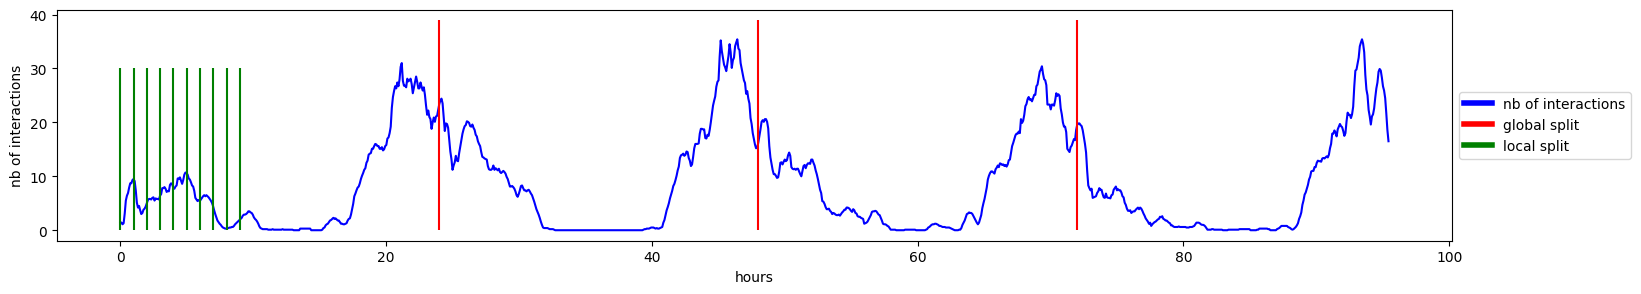

In [52]:
nb_inter = get_number_of_interactions(graphs)
smooth_nb_int = moving_average(nb_inter,10)
plt.figure(figsize=(18,3))
plt.plot(np.arange(0,len(smooth_nb_int)/(3600/gap),gap/3600), smooth_nb_int,color="blue")
plt.xlabel("hours")
plt.ylabel("nb of interactions")

plt.vlines(global_slpit/3600,0,np.max(smooth_nb_int)*1.1,color="red")
plt.vlines(global_slpit*2/3600,0,np.max(smooth_nb_int)*1.1,color="red")
plt.vlines(global_slpit*3/3600,0,np.max(smooth_nb_int)*1.1,color="red")
for i in range(10):
    plt.vlines(local_split*(i)/3600,0,30,color="green")


custom_lines = [Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4)]
plt.legend(custom_lines, ['nb of interactions', 'global split', 'local split'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### split graphs into list of graphs (depending on local splitting)

In [53]:
local_split = int(local_split/(gap+1))
global_slpit = int(global_slpit/(gap+1))

In [54]:
daily_graphs = []

for i in range(int(global_slpit/local_split)):
    daily_graphs.append([])
    
    
hour = 0
c = 1
for i in range(len(graphs)):
    g = graphs[i]
    if i < local_split*c:
        daily_graphs[hour].append(g)
    else:
        c = c + 1
        if hour == len(daily_graphs)-1:
            hour = 0
        else:
            hour = hour + 1
        daily_graphs[hour].append(g)

### count ETNS and store it in dictionaries (one for each local split)

In [55]:
import time 

#for k in [4,6,8,10,25,50]:
for k in [1,2,3,4,5]:
#for k in [1]:
    start = time.time()

    ETNSs = []
    dizs = []
    all_statistics = 0

    for i in range(int(global_slpit/local_split)):
        ETNS = count_ETN(daily_graphs[i],k)
        ETNS = {k: v for k, v in sorted(ETNS.items(),reverse=True, key=lambda item: item[1])}

        ETNSs.append(ETNS)

        diz,stat = get_dict(ETNS,k,return_statistics=True)
        dizs.append(diz)
        all_statistics += stat

    g0 = graphs[0]
    graph_seed = generate_seed_graphs(g0,graphs,k,alpha = 0.5)
    #graph_seed = graphs[:k]

    # decide how many graphs you want to generate
    nb_graphs = len(graphs)

    c =  1
    hour = 0 
    nodes = list(graph_seed[0].nodes())
    tg = graph_seed
    verbose = True
    for i in range(nb_graphs-1):
        if i < local_split*c:
            pos = hour
        else:
            c = c + 1
            if hour == len(daily_graphs)-1:
                hour = 0
            else:
                hour = hour + 1
            pos = hour

        diz = dizs[pos]

        graphs_in = tg[i:i+k]
        g_new = generate_graph_g2(nodes,graphs_in,diz,k,alpha = 0.5)
        tg.append(g_new)

        
    keys_len = 0
    val_len = 0
    for diz in dizs:
        a = np.array(list(diz.values()),dtype=object)
        keys_len += len(diz.keys())
        val_len += len(a.reshape(-1))
    
    
    end = time.time()
    print(k,int(end-start),keys_len,val_len,len(dizs),"stat: ",all_statistics)
    
    
    new_temporal_graph_name = "ETNgen-"+file_name+"-k-"+str(k)
    print(new_temporal_graph_name)
    
    
    edge_list = []
    c = 0 
    gap = 300
    nodes = set()
    for i in tg:
        edges = list(i.edges())

        for a,b in edges:
            edge_list.append([c*gap,a,b])
            nodes.add(a)
            nodes.add(b)
        c = c + 1

    orig_nod = set(tg[0].nodes())
    diff = orig_nod.difference(nodes)
    for i in diff:
        edge_list.append([c*gap,i,i])
        
        
    df_edge_list = pd.DataFrame(edge_list,columns=["time","node_A","node_B"])
    
    df_edge_list.to_csv("variation_of_K_res/"+file_name+"/"+new_temporal_graph_name+".dat",sep=" ",index=False,header=False)
    print(k)

1 8 165 330 24 stat:  86827
ETNgen-LH10-k-1
1
2 18 1537 3074 24 stat:  84965
ETNgen-LH10-k-2
2
3 29 4912 9824 24 stat:  83119
ETNgen-LH10-k-3
3
4 51 7247 14494 24 stat:  81290
ETNgen-LH10-k-4
4
5 62 8709 17418 24 stat:  79469
ETNgen-LH10-k-5
5


In [56]:
import pandas as pd


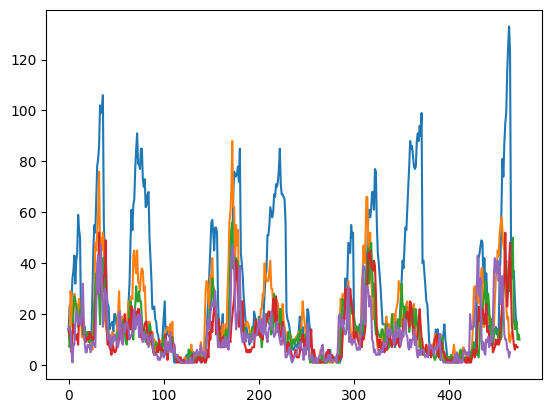

In [57]:
a = pd.read_csv("variation_of_K_res/High_School11/ETNgen-High_School11-k-1.dat",sep=" ",names=["t","a","b"])
_,k1 = np.unique(a.t,return_counts=True)
plt.plot(k1)


a = pd.read_csv("variation_of_K_res/High_School11/ETNgen-High_School11-k-2.dat",sep=" ",names=["t","a","b"])
_,k1 = np.unique(a.t,return_counts=True)
plt.plot(k1)

a = pd.read_csv("variation_of_K_res/High_School11/ETNgen-High_School11-k-3.dat",sep=" ",names=["t","a","b"])
_,k1 = np.unique(a.t,return_counts=True)
plt.plot(k1)

a = pd.read_csv("variation_of_K_res/High_School11/ETNgen-High_School11-k-4.dat",sep=" ",names=["t","a","b"])
_,k1 = np.unique(a.t,return_counts=True)
plt.plot(k1)

a = pd.read_csv("variation_of_K_res/High_School11/ETNgen-High_School11-k-5.dat",sep=" ",names=["t","a","b"])
_,k1 = np.unique(a.t,return_counts=True)
plt.plot(k1)

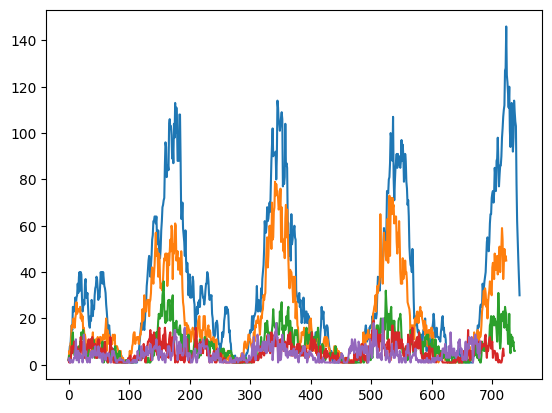

In [58]:
file_name ="LH10"
a = pd.read_csv("variation_of_K_res/"+file_name+"/ETNgen-"+file_name+"-k-1.dat",sep=" ",names=["t","a","b"])
_,k1 = np.unique(a.t,return_counts=True)
plt.plot(k1)


a = pd.read_csv("variation_of_K_res/"+file_name+"/ETNgen-"+file_name+"-k-2.dat",sep=" ",names=["t","a","b"])
_,k1 = np.unique(a.t,return_counts=True)
plt.plot(k1)

a = pd.read_csv("variation_of_K_res/"+file_name+"/ETNgen-"+file_name+"-k-3.dat",sep=" ",names=["t","a","b"])
_,k1 = np.unique(a.t,return_counts=True)
plt.plot(k1)

a = pd.read_csv("variation_of_K_res/"+file_name+"/ETNgen-"+file_name+"-k-4.dat",sep=" ",names=["t","a","b"])
_,k1 = np.unique(a.t,return_counts=True)
plt.plot(k1)

a = pd.read_csv("variation_of_K_res/"+file_name+"/ETNgen-"+file_name+"-k-5.dat",sep=" ",names=["t","a","b"])
_,k1 = np.unique(a.t,return_counts=True)
plt.plot(k1)

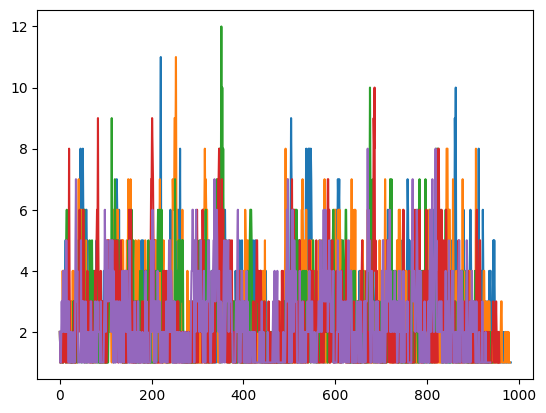

In [59]:
file_name ="InVS13"
a = pd.read_csv("variation_of_K_res/"+file_name+"/ETNgen-"+file_name+"-k-1.dat",sep=" ",names=["t","a","b"])
_,k1 = np.unique(a.t,return_counts=True)
plt.plot(k1)


a = pd.read_csv("variation_of_K_res/"+file_name+"/ETNgen-"+file_name+"-k-2.dat",sep=" ",names=["t","a","b"])
_,k1 = np.unique(a.t,return_counts=True)
plt.plot(k1)

a = pd.read_csv("variation_of_K_res/"+file_name+"/ETNgen-"+file_name+"-k-3.dat",sep=" ",names=["t","a","b"])
_,k1 = np.unique(a.t,return_counts=True)
plt.plot(k1)

a = pd.read_csv("variation_of_K_res/"+file_name+"/ETNgen-"+file_name+"-k-4.dat",sep=" ",names=["t","a","b"])
_,k1 = np.unique(a.t,return_counts=True)
plt.plot(k1)

a = pd.read_csv("variation_of_K_res/"+file_name+"/ETNgen-"+file_name+"-k-5.dat",sep=" ",names=["t","a","b"])
_,k1 = np.unique(a.t,return_counts=True)
plt.plot(k1)